In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader #dataloader wraps an iterable around the Dataset to enable easy access to the samples.
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [2]:
#print(len(test_data))

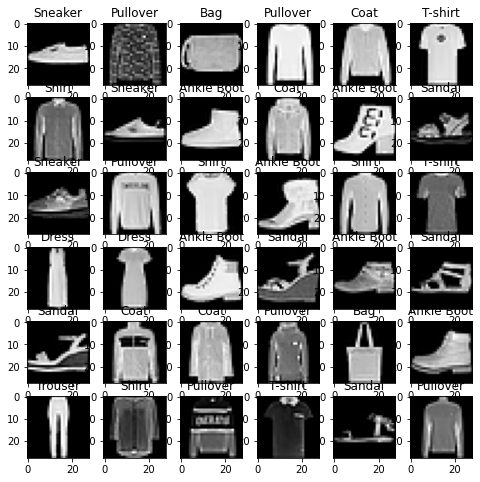

In [3]:
labels_map = {
        0: "T-shirt",
        1: "Trouser", 
        2: "Pullover", 
        3: "Dress", 
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
}


#notes
#len function returns the number of samples in dataset
#PLT.FIGURE allows us make a figure object and to tweak the size of the figure
#axis on or off shows the figure dimensions
#gray necessary to get any image to show up
#plt.title(labels_map[label]) assigns the images the labels that we just defined above
#plt.imshow basically is just a function that takes numerical image data and puts it back into a visual form


figure = plt.figure(figsize=(8, 8))
cols, rows = 6, 6
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("on")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()
    

In [2]:
import os
import pandas as pd
from torchvision.io import read_image
import numpy as np

class CustomImageDataset():
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
#preparing data for training with dataloaders

from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


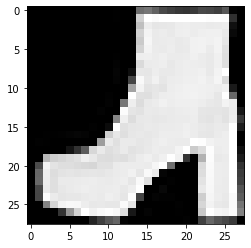

Label: 9


In [6]:
# Display image and label
# returns feature batch shape: torch.size([64, 1, 28, 28]) where 64 is batch size, 1 is color channel (gray scale), and 28x28 is the size
#this block basically took image 0 from this batch size of 64, and labeled it as "5" which corresponds to a sandal, which we previously defined
#this isn't actually predicting anything yet, it's just pairing the labels with the images 

#questions
#what is going on in line 1?
#why is the image returned 28x28...thought that above we said the figures should be 8x8?

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


Understanding the following cell:
    

self.flatten --> self will refer to the specific instance of the Neural Network class...refer below to where we define model as an instance of Neural Network and send it to device. Remember earlier where our images were a square, when you printed them out? Flatten just takes that square and turns it into a 1 dimensional set.

relu is rectified linear unit for activation function. Each layer of neurons need an activation function to tell them what to do, Relu effectively means "If X>0 return X, else return 0" -- so what it does it it only passes values 0 or greater to the next layer in the network. Also pay attention to the arguments given in each linear layer (input, output)...the last layer gives an output of 10 neurons because we want the final tensor coming from the last neuron to predict labels 0-9 (which has a dimension of 10). If we were predicting something binary (like surgical margin positivity), then we would want the final layer to be something like nn.Linear(512, 1) because the output can be a single neuron.

Every nn.Module subclass implements the operations on input data in the forward method. Note how it refers locally to the self.linear_relu_stack attribute after flattening. Thus x will be passed through each layer of the neural network as defined above

In [8]:

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [9]:
#We create an instance of NeuralNetwork, and move it to the device, and print its structure

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


Understanding the Following Cell:

To use the model, we pass it the input data. This executes the model’s forward method, along with some background operations. From pytorch tutorial: "Do not call model.forward() directly!"

Calling the model on the input returns a 10-dimensional tensor with raw predicted values for each class. We get the prediction probabilities by passing it through an instance of the nn.Softmax module pred_probability = nn.Softmax(dim=1)(logits)....***In the case of binary classification, we used the sigmoid function to turn an output activation into a probability value between 0 and 1. In the n-ary case, we use the multivariate analog of the sigmoid function called the softmax.***

Softmax is a mathematical function that converts a vector of numbers into a vector of probabilities

network is configured to output N values, one for each class in the classification task, and the softmax function is used to normalize the outputs, converting them from weighted sum values into probabilities that sum to one. Each value in the output of the softmax function is interpreted as the probability of membership for each class

and then we use the argmax method which "Returns the indices of the maximum value of all elements in the input tensor".....so if the predicted probaility for a certain label is highest for label 6, for example (shirt), then argmax will return tensor([6]) to indicate the index where the probability was highest

***unclear on why the dim=1 and why this is passed as an argument for argmax***
-->***basically means "use the last layer of the neural network to predict***

***unclear on why the forward method can't be called directly***




In [12]:
#predicts the class of a random image in the dataset

X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")
print("Y pred: ", y_pred[0])


print("Logits: ", logits)
print("Pred prob: ",pred_probab)

Predicted class: tensor([8])
Y pred:  tensor(8)
Logits:  tensor([[0.0000, 0.0305, 0.0000, 0.0000, 0.0700, 0.0823, 0.0000, 0.0000, 0.1145,
         0.0556]], grad_fn=<ReluBackward0>)
Pred prob:  tensor([[0.0965, 0.0994, 0.0965, 0.0965, 0.1034, 0.1047, 0.0965, 0.0965, 0.1082,
         0.1020]], grad_fn=<SoftmaxBackward>)


Predicted class: tensor([8])
tensor([[0.0949, 0.1077, 0.0949, 0.0949, 0.1039, 0.1048, 0.0949, 0.0949, 0.1101,
         0.0990]], grad_fn=<SoftmaxBackward>)


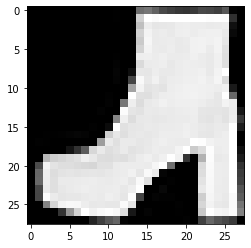

Label: 9
Ankle Boot


In [11]:
#experimenting to see if I can get the model to predict the first image label, which should be a sandal (label 5)
index = 0
first_img = train_features[index]
output = model(first_img)
first_probab = nn.Softmax(dim=1)(output)
first_pred = first_probab.argmax(1)
print(f"Predicted class: {first_pred}")
print(first_probab)

img = train_features[index].squeeze()
label = train_labels[index]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")
print(labels_map[int(train_labels[index])])

In [13]:
# We define the following hyperparameters for training:
#  - **Number of Epochs** - the number times to iterate over the dataset
#  - **Batch Size** - the number of data samples propagated through the network before the parameters are updated
#  - **Learning Rate** - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

learning_rate = 1e-3
batch_size = 64

In [14]:
# Initialize the loss function, Loss function measures the degree of dissimilarity of obtained result to the target value, 
#and it is the loss function that we want to minimize during training. this one is best for classification tasks
loss_fn = nn.CrossEntropyLoss()

In [15]:
# We initialize the optimizer by registering the model's parameters that need to be trained, and passing in the learning rate hyperparameter.

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [1]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()  #sets gradients of all optimized torch tensors to 0
        loss.backward()   #READ THIS
                          #The change in the loss for a small change in an input weight is the gradient of that weight and is calculated using backpropagation
                         #backpropagation is kicked off when we call .backward() on the error tensor (thus loss.backward() written here). 
                        #Autograd then calculates and stores the gradients for each model parameter in the parameter’s .grad attribute.
        optimizer.step() #Finally, we call .step() to initiate gradient descent. The optimizer adjusts each parameter by its gradient stored in .grad

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [17]:
loss_fn = nn.CrossEntropyLoss() #loss_fn defined as cross entropy loss because this is the best function in classication tasks
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.305146  [    0/60000]
loss: 2.288736  [ 6400/60000]
loss: 2.290218  [12800/60000]
loss: 2.287543  [19200/60000]
loss: 2.252053  [25600/60000]
loss: 2.262149  [32000/60000]
loss: 2.249827  [38400/60000]
loss: 2.243872  [44800/60000]
loss: 2.205529  [51200/60000]
loss: 2.245895  [57600/60000]
Test Error: 
 Accuracy: 46.5%, Avg loss: 0.034804 

Epoch 2
-------------------------------
loss: 2.243997  [    0/60000]
loss: 2.198245  [ 6400/60000]
loss: 2.156460  [12800/60000]
loss: 2.191744  [19200/60000]
loss: 2.152743  [25600/60000]
loss: 2.162756  [32000/60000]
loss: 2.177440  [38400/60000]
loss: 2.061673  [44800/60000]
loss: 2.070586  [51200/60000]
loss: 2.110647  [57600/60000]
Test Error: 
 Accuracy: 51.8%, Avg loss: 0.032862 

Epoch 3
-------------------------------
loss: 2.096102  [    0/60000]
loss: 2.005380  [ 6400/60000]
loss: 2.079432  [12800/60000]
loss: 2.026461  [19200/60000]
loss: 1.994585  [25600/60000]
loss: 2.057062  [32000/600